In [1]:
#Chargement des librairies
import numpy as np
import pandas as pd

# Gestion des fichiers/images
import os
from PIL import Image, ImageFilter, ImageStat

import matplotlib.pyplot  as plt
from matplotlib import style
%matplotlib inline

import cv2

In [2]:
# liste des répertoires qui contiennent les datas
data_dir = {'COVID':  '../data/COVID',
            'Normal': '../data/Normal',
            'Viral Pneumonia': '../data/Viral Pneumonia',
            'Lung Opacity': '../data/Lung_Opacity'}

# Construction d'un échantillon pour le Pre-Processing

Notre échantillon doit permettre d'expérimenter l'étape de pré-processing sur un ensemble d'images représentatif du jeu d'image global.

Les images choisies doivent donc correspondre aux différentes classes d'images contenues dans le dataset (COVID, Normal...), mais également aux différents cas rencontrés lors de l'étape d'exploration des données (problèmes de contrastes, de luminosité, de netteté, éléments pouvant perturber l'analyse...)

In [3]:
# Chargement du df des metadatas construit lors de l'exploration des données
df = pd.read_csv('../data/metadata.csv', index_col=0)

La qualité et la taille des radios semblent dépendantes de la source des données.<br>
L'échantillon d'images sera donc sélectionné en tenant compte du target mais également de la source de données.

Pour chaque target/source de données, nous allons donc sélectionner : 
 - 3 images avec un bon score <i>(calculé lors de l'exploration des données)</i> ;
 - 3 images avec un mauvais score ;
 - et 4 images choisies aléatoirement.
 
De plus, nous allons ajouter quelques cas intéressants rencontrés lors de l'exploration des données<sup>[1]</sup>.

In [4]:
# Liste les targets du dataframe
targets = df['target'].unique()
idx = []  # Liste des index sélectionnés

# Pour chaque target: on sélectionne une liste d'images
for t in targets:
    # Pour chaque source d'images (la qualité et la taille des radios peut dépendre de la source des données)
    for u in df.loc[df['target']==t, 'URL'].unique():
        df2 = df[(df['target']==t) & (df['URL']==u)]
        # 3 images avec le meilleur score
        idx += df2.head(3).index.to_list() 
        # 3 images avec le mons bon score
        idx += df2.tail(3).index.to_list()
        # 4 images au hasard dans le reste des images
        idx += df2.iloc[3:-3, :].sample(n=4, random_state=7).index.to_list()
        
# Force la liste d'image présentée lors de l'exploration
idx.append('COVID-312')
idx.append('COVID-1361')
idx.append('COVID-1880')
idx.append('COVID-168')
idx.append('COVID-1837')
idx.append('COVID-1841')


Les images et les masques sélectionnés sont copiés dans le dossier `/data/sample`.

In [5]:
# Copie la liste d'images dans le répertoire de destination
from shutil import copy2

# Pour chaque index du df sélectionné, 
# copie l'image et le masque vers le dossier ../data/sample/image et /masks
for i in idx:
    file = df.loc[i, 'image_file']
    mask = df.loc[i, 'mask_file']
    copy2(file, '../data/sample/images/')
    copy2(mask, '../data/sample/masks/')
    
# Enregistrement du fichier de metadatas
df.loc[idx].to_csv('../data/sample/metadata.csv')

**Affichage de l'échantillon construit**

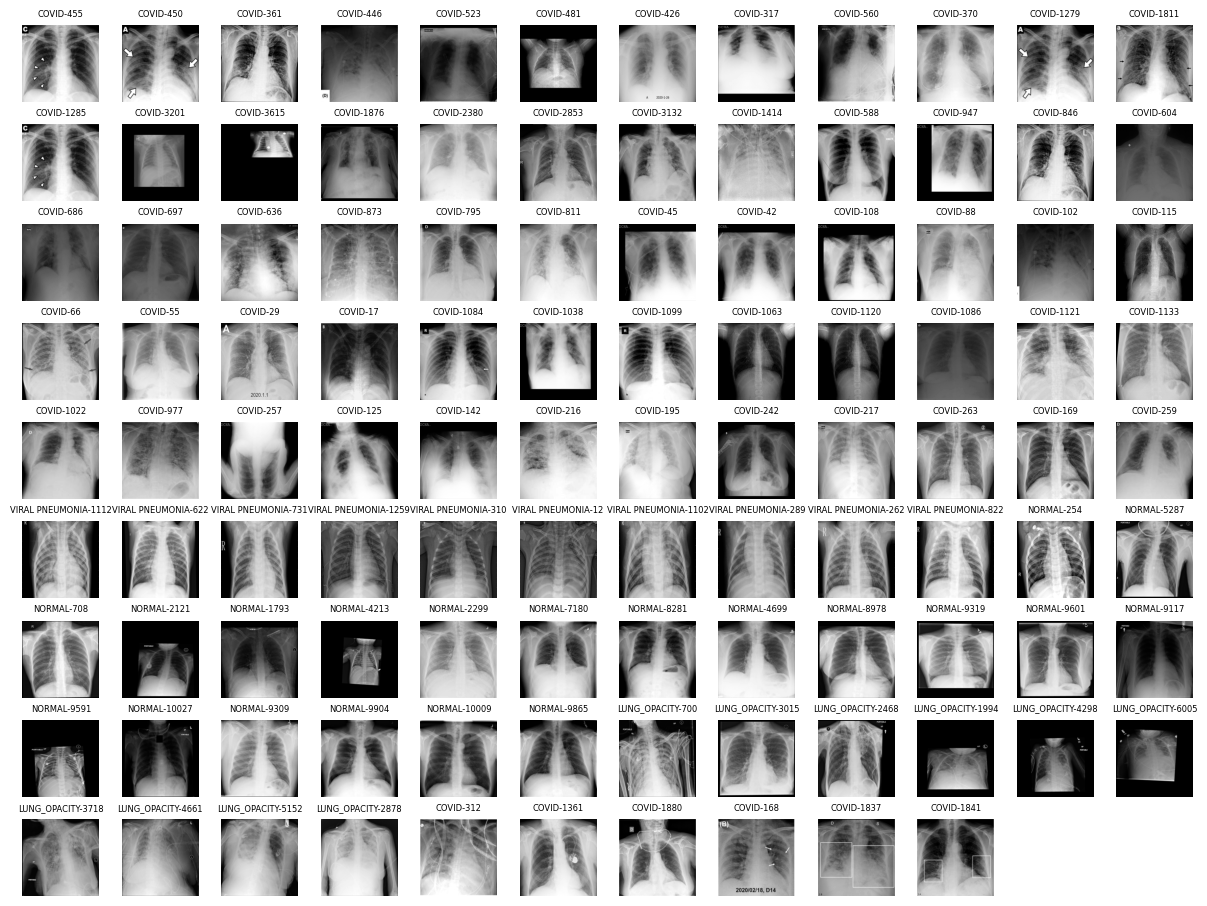

In [6]:
nb_cols = 12
nb_lignes = int(np.ceil(len(idx) / nb_cols))

plt.figure(figsize=(12, nb_lignes*12/nb_cols))
plt.set_cmap('gray')

for n, i in enumerate(idx):
    plt.subplot(nb_lignes, nb_cols, n+1)
    plt.title(i, fontdict={'size': 6})
    plt.imshow(plt.imread(df.loc[i, 'image_file']))
    plt.axis('off')

plt.tight_layout(pad=0.5)
plt.show()

L'échantillon de test semble assez représentatif du jeu de données d'origine.

# Etapes du Preprocessing

## Chargement des images en niveau de gris

## Redimensionnement des images en 256x256

Comme nous l'avons constaté lors de l'étape d'exploration des données, les images ne sont pas de la même taille que les masques associés. Nous allons donc devoir redimensionner les images pour qu'elles fassent toutes 256x256 px.

## Suppression des éventuels cadres noirs

Cette étape doit nous permettre de supprimer les cadres noirs présent autour de certaines images et qui risquent de perturber l'entrainement du modèle. Pendant la phase de redimensionnement, les masques vont également être redimensionnés pour qu'ils continuent de correspondre aux poumons.

**Déclaration de la fonction**

In [7]:
def delete_frame(image, mask):
    """Supprime le cadre noir éventuellement autour de l'image.
    Si l'image est modifiée, le masque l'est également pour continuer de 
    correspondre à l'image.
    
    Paramètre:
    - image : image à analyser et éventuellement à corriger
    - mask  : masque de l'image
    
    Retourne:
    - image corrigée en conservant la taille initiale
    - masque corrigé
    """
    # Récupère les indices des pixels <> 0
    X, Y= image.nonzero()
    
    # Fixe une limite de cadre
    # pour éviter de redimensionner toutes les images pour un bord de 1 px
    if (X.min() < 5) and (X.max() > 250) and (Y.min() < 5) and (Y.max() > 250):
        pass
    
    else:
        # Les valeurs min et max peuvent être utilisées pour déterminer la région qui comporte la radio
        roi_img = img[X.min():X.max(), Y.min():Y.max()]
        roi_msk = mask[X.min():X.max(), Y.min():Y.max()]
        image  = cv2.resize(roi_img, dsize=(256,256))
        mask = cv2.resize(roi_msk, dsize=(256,256))
        
    return image, mask

**Tester la fonction "delete_frame"**

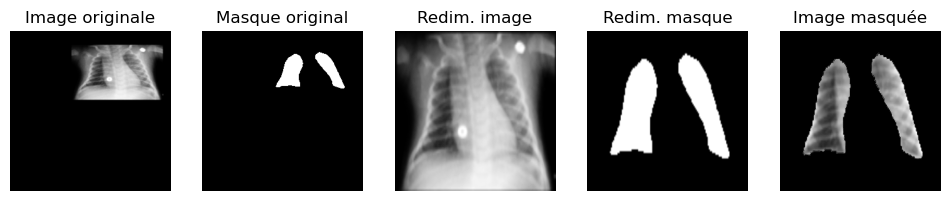

In [8]:
# Charger un exemple d'image et le masque correspondant
img = cv2.imread("../data/sample/images/COVID-3615.png", cv2.IMREAD_GRAYSCALE)
msk = cv2.imread("../data/sample/masks/COVID-3615.png", cv2.IMREAD_GRAYSCALE)

# Redimensionner l'image pour qu'elle corresponde au masque
img = cv2.resize(img, dsize=(256,256))

plt.figure(figsize=(12,8))
plt.set_cmap('gray')

#Afficher l'image et le masque originaux

plt.subplot(151, title='Image originale')
plt.axis('off')
plt.imshow(img)
plt.subplot(152, title='Masque original')
plt.axis('off')
plt.imshow(msk)

# Supprimer le cadre noir

img, msk = delete_frame(img, msk)

#Afficher l'image et le masque redimensionnés

plt.subplot(153, title='Redim. image')
plt.axis('off')
plt.imshow(img)
plt.subplot(154, title='Redim. masque')
plt.axis('off')
plt.imshow(msk)

#Afficher l'image masquée

plt.subplot(155, title='Image masquée')
plt.axis('off')
plt.imshow(cv2.resize(img, (256,256)) & msk)

plt.show()

## Appliquer le masque des images

Appliquer le masque à une image revient à faire une opération booléenne sur une image. <br>
Le masque sera donc appliqué sur l'image en utilisant un opérateur ET logique (&).

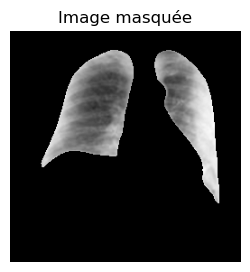

In [9]:
fic_image = 'COVID-1022.png'
# Chargement de l'image
image = cv2.imread(f"../data/sample/images/{fic_image}", cv2.IMREAD_GRAYSCALE)
# Redimensionner l'image pour qu'elle corresponde au masque
image = cv2.resize(image, dsize=(256,256))
mask  = cv2.imread(f"../data/sample/masks/{fic_image}", cv2.IMREAD_GRAYSCALE)
#Appliquer le masque
image = image & mask
#Afficher l'image masquée
plt.figure(figsize=(3,3))
plt.set_cmap('gray')
plt.axis('off')
plt.title('Image masquée')
plt.imshow(image)
plt.show()

## Suppression des annotations

Le process de suppression des annotations consiste à :
 - détecter les contours avec un fort contraste dans la région pulmonaire, 
 - supprimer les contours
 - remplacer les zones supprimées en appliquant la technique du "Inpaint".


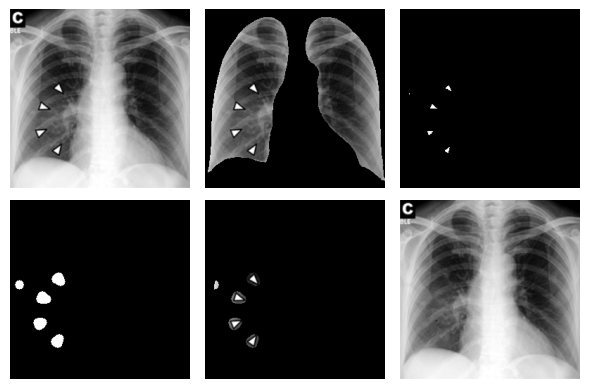

In [10]:
fic = '../data/sample/images/COVID-455.png'
msk = '../data/sample/masks/COVID-455.png'

#fic = '../data/sample/images/COVID-811.png'
#msk = '../data/sample/masks/COVID-811.png'

#fic = '../data/sample/images/COVID-1279.png,
#msk = '../data/sample/masks/COVID-1279.png'

# fic = '../data/COVID/images/COVID-1837.png'
# msk = '../data/COVID/masks/COVID-1837.png'

# fic = '../data/COVID/images/COVID-1361.png'
# msk = '../data/COVID/masks/COVID-1361.png'


# Chargement image ------------------------------------------------------------

image = cv2.imread(fic,cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256,256))

plt.figure(figsize=(6,4))
plt.set_cmap('gray')
plt.subplot(231)
plt.imshow(image)
plt.axis('off')


# Chargement et application du masque -----------------------------------------

mask  = cv2.imread(msk,cv2.IMREAD_GRAYSCALE)
image = image & mask

plt.subplot(232)
plt.imshow(image)
plt.axis('off')


# Recherche de contours -------------------------------------------------------

_, img = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)


plt.subplot(233)
plt.imshow(img, 'gray')
plt.axis('off');

contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
inpaint_mask = cv2.drawContours(img, contours=contours, contourIdx=-1, color=255, thickness=12)

plt.subplot(234)
plt.imshow(inpaint_mask, 'gray')
plt.axis('off')

plt.subplot(235)
plt.imshow(image & inpaint_mask, 'gray')
plt.axis('off')

# Remplace les zones annotées -------------------------------------------------

image = cv2.imread(fic,cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image,(256,256))
final = cv2.inpaint(image, inpaint_mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)


plt.subplot(236)
plt.imshow(final, 'gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Egalisation des histogrammes

Cette étape doit nous permettre d'améliorer le contraste des images.  Elle sert à étendre la plage de valeurs d’une image en étalant de manière uniforme les niveaux de gris de l’image sur tout l’intervalle de valeurs disponibles (0 à 255). Cela permet de corriger les asymétries trouvées au niveau de la phase d'exploration des données.

**Déclaration de la fonction "egalisation"**

In [11]:
def egalisation(image):
    """Etend la plage de valeurs d’une image en étalant de 
    manière uniforme les niveaux de gris de sur tout l’intervalle 
    de valeurs disponibles.
    Améliore le contraste de l'image.
    
    Paramètre:
    - image : image à corriger
    
    Retourne:
    - image corrigée 
   
    """
#Egalisation des histogrammes à l'aide du package Opencv
    img_eq=cv2.equalizeHist(image)
    
    return img_eq


**Tester la fonction "egalisation"**

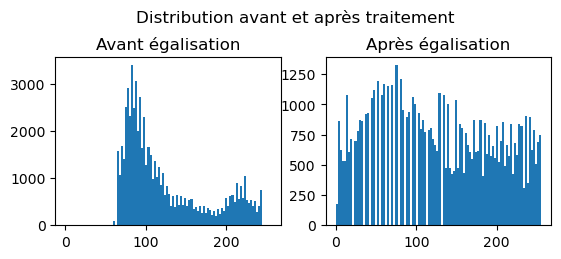

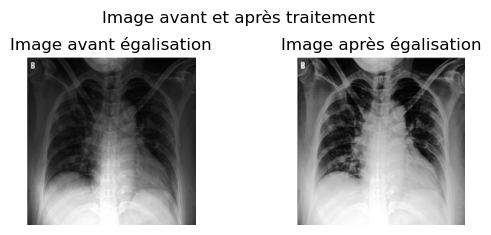

In [12]:
# Charger un exemple d'image et le masque correspondant
img = cv2.imread('../data/COVID/images/COVID-17.png', cv2.IMREAD_GRAYSCALE)

# Redimensionner l'image pour qu'elle corresponde au masque
img = cv2.resize(img, dsize=(256,256))

#Egalisation de l'histogramme
img_traite=egalisation(img);

#Affichage de la distribution avant et après traitement
fig1 = plt.figure()
fig1.suptitle('Distribution avant et après traitement')
ax = fig1.add_subplot(2,2,1, title="Avant égalisation")
plt.hist(img.flat,bins=100,range=(0,255));
ax = fig1.add_subplot(2,2,2, title="Après égalisation")
plt.hist(img_traite.flat,bins=100,range=(0,255));
# Affichage des images avant et après traitement
fig2 = plt.figure()
fig2.suptitle('Image avant et après traitement')
ax = fig2.add_subplot(2,2,1, title='Image avant égalisation')
plt.imshow(img)
plt.set_cmap('gray')
plt.axis('off');
ax = fig2.add_subplot(2,2,2, title='Image après égalisation')
plt.imshow(img_traite)
plt.set_cmap('gray')
plt.axis('off');

Comme nous pouvons le voir sur la figure ci-dessus, si nous comparons les deux images, nous pouvons constater que le contraste de l'image 
a été clairement amélioré en effectuant une égalisation. Le succès de la procédure est confirmé par l'histogramme associé à chaque image, montrant que sa gamme a été étendue pour occuper l'ensemble du spectre des niveaux. 


## Application d'un 'Gaussian Blur'

L'égalisation de l'histogramme est une étape très importante pour améliorer le contraste de l'image, cependant elle peut également causer des bruits sur l'image.<br>

Pour réduire ce bruit, on peut utiliser le filtrage gaussien(Gaussian Blur) qui permet de supprimer les détails inutiles susceptibles de perturber le réseau neuronal.<br>

Une étude <sup>[2]</sup> a prouvé que la combinaison de ces deux méthodes (HistogramEqualisation+Gaussian Blur) améliore le résultat de la classification des images.<br>

La taille du filter kernel a été déterminée par des expérimentations <sup>[2]</sup> et fixée à 5 × 5 pour optimiser son efficacité.

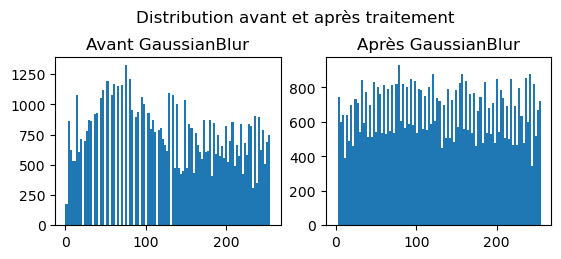

In [13]:
#Appliquer le filtre Gaussian Blur sur l'image traitée ci-dessus
img_filtre=cv2.GaussianBlur(img_traite, ksize=(5,5), sigmaX=0)


#Affichage de la distribution avant et après traitement
fig = plt.figure()
fig.suptitle('Distribution avant et après traitement')
ax = fig.add_subplot(2,2,1, title="Avant GaussianBlur")
plt.hist(img_traite.flat,bins=100,range=(0,255));
ax = fig.add_subplot(2,2,2, title="Après GaussianBlur")
plt.hist(img_filtre.flat,bins=100,range=(0,255));


Nous pouvons constater que la distibution de l'histogramme de l'image a été clairement amélioré en effectuant le filtrage avec GaussianBlur. 

## Normalisation

La normalisation des valeurs de pixel est souvent nécessaire pour que 
les valeurs soient dans une plage spécifique, ce qui peut aider le modèle à converger plus rapidement. On peut normaliser en divisant les valeurs de pixel par 255.0 pour ramener les valeurs dans l'intervalle [0, 1].

**Déclaration de la fonction "normalize"**

In [14]:
def normalize(image):
    """divisant les valeurs de pixel par 255.0 
    pour ramener les valeurs dans l'intervalle [0, 1]
    
    Paramètre:
    - image : image à normalisée
    
    Retourne:
    - image normalisée 
   
    """
    return (image / 255)

**Tester la fonction "egalisation"**

In [15]:
#Appliquer la normalisation sur l'image traitée ci-dessus
normalize(img_filtre)

array([[0.68235294, 0.65882353, 0.62352941, ..., 0.60392157, 0.60392157,
        0.60392157],
       [0.6       , 0.56470588, 0.51764706, ..., 0.48235294, 0.48627451,
        0.48627451],
       [0.45490196, 0.40784314, 0.34117647, ..., 0.27058824, 0.2745098 ,
        0.27843137],
       ...,
       [0.56078431, 0.51764706, 0.45490196, ..., 0.50588235, 0.48235294,
        0.4745098 ],
       [0.55294118, 0.50980392, 0.44313725, ..., 0.50196078, 0.48235294,
        0.47058824],
       [0.54901961, 0.50588235, 0.43921569, ..., 0.50196078, 0.48235294,
        0.47058824]])

On remarque que les valeurs sont bien entre 0 et 1.

# Généralisation sur l'échantillon du preprocessing

Après avoir expérimenté diverses méthodes du prétraitement sur plusieurs images et confirmer leur efficacité. nous allons procéder à la création d'une fonction qu'on nomme **"preprocessing"** et  qui synthétisera l'ensemble des étapes précédemment réalisées.
Ensuite, nous utiliserons cette fonction sur notre échantillon préalablement préparé.  

In [16]:
def preprocessing (image, mask):
    """Cette fonction réalise:
       - le Redimensionnement de l'image
       - Suppression des éventuels cadres noirs
       - Application du masque
       - Suppression des annotations
       - Egalisation des histogrammes
       - Application du Gaussian Blur
       - Normalisation
    Paramètre:
    - image : image à pré-traiter
    - mask  : masque de l'image
    Retourne:
    - image pré-traitée 
       
    """
    
    # Redimensionnement 256x256 de l'image
    image = cv2.resize(image, dsize=(256, 256))
    
    
    # Suppression des éventuels cadres noirs 
    # Récupère les indices des pixels <> 0
    X, Y = image.nonzero()
    # Fixe une limite de cadre
    # pour éviter de redimensionner toutes les images pour un bord de 1 px
    if (X.min() < 5) and (X.max() > 250) and (Y.min() < 5) and (Y.max() > 250):
        pass
    else:
        # Les valeurs min et max peuvent être utilisées pour déterminer la région qui comporte la radio
        roi_img = image[X.min():X.max(), Y.min():Y.max()]
        roi_msk = mask[X.min():X.max(), Y.min():Y.max()]
        image  = cv2.resize(roi_img, dsize=(256,256))
        mask = cv2.resize(roi_msk, dsize=(256,256))
        
    
    # Appliquer le masque
    image = image & mask
    
    
    # Suppression des annotations
    (_, img) = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    inpaint_mask = cv2.drawContours(img, contours=contours, contourIdx=-1, color=255, thickness=12)
    # Remplace les zones annotées -------------------------------------------------
    image = cv2.inpaint(image, inpaint_mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)
    
    
    # Egalisation
    image=cv2.equalizeHist(image)    
    
    
    # Gaussian Blur
    image=cv2.GaussianBlur(image, ksize=(5,5), sigmaX=0)
    
    
    # Normalisation
    image = image / 255
    
    return image

In [17]:
# Boucle sur l'échantillon d'images

# Chargement du DataFrame des échantillons
df = pd.read_csv('../data/sample/metadata.csv', index_col=0)

# Pour chaque image du df
for idx in df.index:
    
    # Chargement de l'image en niveau de gris
    image = cv2.imread(df.loc[idx, 'image_file'], cv2.IMREAD_GRAYSCALE)
    mask  = cv2.imread(df.loc[idx, 'mask_file'], cv2.IMREAD_GRAYSCALE)
    
    image = preprocessing(image, mask)
  
    # Enregistrement de l'image
    #cv2.imwrite(f"../data/sample/preprocessed/{idx}", image)
    np.save(f"../data/sample/preprocessed/{idx}.npy", image, allow_pickle=False)
    
    

# Résultats

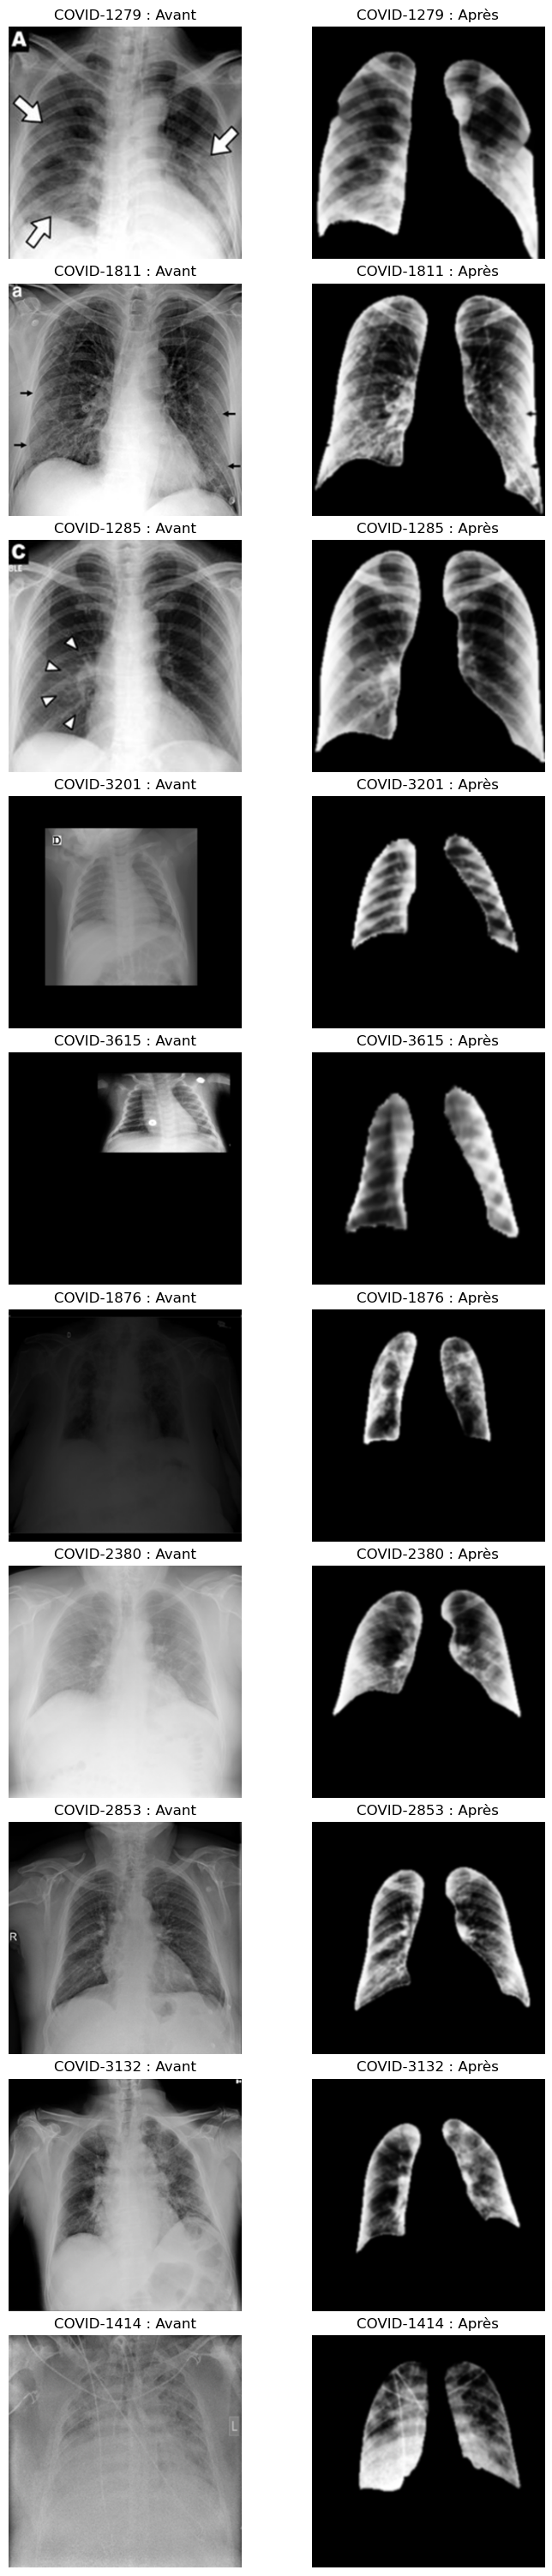

In [18]:
plt.figure(figsize=(8,30))

for i in range(10, 20):
    idx = df.index[i]

    img_avant = cv2.imread(f"../data/sample/images/{idx}.png")
    img_apres = np.load(f"../data/sample/preprocessed/{idx}.npy", allow_pickle=False)
    
    plt.subplot(10, 2, (i-10)*2 + 1, title= idx + ' : Avant')
    plt.axis('off')
    plt.imshow(img_avant)
    
    plt.subplot(10, 2, (i-10)*2 + 2, title= idx + ' : Après')
    plt.axis('off')
    plt.imshow(img_apres)

plt.tight_layout(pad=0.5)
plt.show()

# Data Augmentation

D’un  autre  côté,  comme  nous  l’avons  constaté  lors de l’étape de l’exploration des  données,  il  y  a  un 
déséquilibre marqué dans la répartition des classes à prédire. Certaines classes minoritaires ("Covid" et "Viral 
Pneumonia") peuvent être sous-représentées ce qui peut nuire à la performance du modèle. D’autres classes 
majoritaires  comme  « Normal »  (50%)  peuvent  être  dominantes.  Pour  faire  face  à  ce  problème,  on  peut 
envisager des stratégies de gestion des équilibres comme la data augmentation.

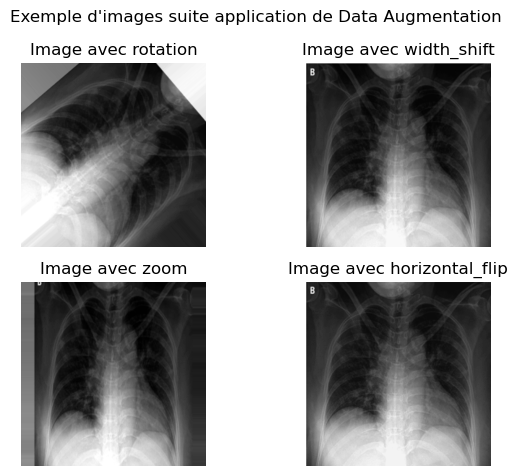

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Créer des générateurs de données 
datagen_1 = ImageDataGenerator(rotation_range=60)

datagen_2 = ImageDataGenerator(width_shift_range=0.2)
                            
datagen_3 = ImageDataGenerator(zoom_range=0.2)

datagen_4 = ImageDataGenerator(horizontal_flip=0.2)

# Importer un exemple d'une image 
img = cv2.imread('../data/COVID/images/COVID-17.png', cv2.IMREAD_GRAYSCALE)

# Appliquer la génération des données
img=img.reshape(img.shape+(1,))
batch_size = 1
batch_1 = next(datagen_1.flow(np.array([img]), batch_size=batch_size))
batch_2 = next(datagen_2.flow(np.array([img]), batch_size=batch_size))
batch_3 = next(datagen_3.flow(np.array([img]), batch_size=batch_size))
batch_4 = next(datagen_4.flow(np.array([img]), batch_size=batch_size))

    

fig = plt.figure()

fig.suptitle("Exemple d'images suite application de Data Augmentation")

ax = fig.add_subplot(2,2,1, title="Image avec rotation")
image_1 = batch_1[0].astype('uint8')
plt.axis('off')
plt.imshow(image_1)


ax = fig.add_subplot(2,2,2, title="Image avec width_shift")
image_2 = batch_2[0].astype('uint8')
plt.axis('off')
plt.imshow(image_2)

ax = fig.add_subplot(2,2,3, title="Image avec zoom")
image_3 = batch_3[0].astype('uint8')
plt.axis('off')
plt.imshow(image_3)

ax = fig.add_subplot(2,2,4, title="Image avec horizontal_flip")
image_4 = batch_4[0].astype('uint8')
plt.axis('off')
plt.imshow(image_4)

plt.tight_layout(pad=1)

plt.show()

# Références

[1] juin23_cds_radio_covid : exploratory_data_analysis - Perturbateurs d'aprentissage ou de prédiction<br/>
https://github.com/DataScientest-Studio/juin23_cds_radio_covid/blob/main/notebooks/exploratory_data_analysis.ipynb

[2] - Pre-processing methods in chest X-ray image classification Agata Giełczyk, , Writing ,Anna Marciniak,  Martyna Tarczewska,and Zbigniew Lutowski https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8982897/

